In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Loading data
train_dataset = torchvision.datasets.CIFAR10(root="/deep_takaya/self_study/deep_learning/data", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.CIFAR10(root="/deep_takaya/self_study/deep_learning/data", train=False, transform=transforms.ToTensor(), download=True)
image, label = train_dataset[0]

# Difinition of Dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=2)

/root/.pyenv/versions/3.9.2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


170499072it [00:11, 15342869.30it/s]                                            


Extracting /deep_takaya/self_study/deep_learning/data/cifar-10-python.tar.gz to /deep_takaya/self_study/deep_learning/data
Files already downloaded and verified


In [15]:
train_dataset.data.ndim

4

In [2]:
# definition of the network
class AlexNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.classifier = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x), inplace=True), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x), inplace=True), kernel_size=2, stride=2)
        x = F.relu(self.conv3(x), inplace=True)
        x = F.relu(self.conv4(x), inplace=True)
        x = F.max_pool2d(F.relu(self.conv5(x), inplace=True), kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

net = AlexNet().to(device)

In [3]:
# loss function and optimization function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [5]:
# training
num_epochs = 20

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train===========================
    net.train()
    
    for i, (images, labels) in enumerate(train_loader):
        # Don't be adapted view()
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(images)
        loss = criterion(outputs, labels)
        
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        
        loss.backward()
        optimizer.step()
        
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val===============================
    net.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            # Don't be adapted view()
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
        
        print("Epoch [{}/{}], Loss: {loss:.4f}, valloss: {val_loss:.4f}, val_acc: {val_acc:.4f}".format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
        
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)

Epoch [1/20], Loss: 0.0260, valloss: 0.0237, val_acc: 0.4346


KeyboardInterrupt: 

In [11]:
labels.shape

torch.Size([64])


KeyboardInterrupt



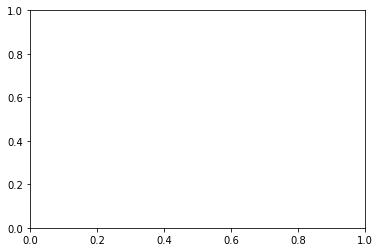

In [7]:
# plot results
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color="blue", linestyle="-", label="train_loss")
plt.plot(range(num_epochs), val_loss_list, color="green", linestyle="--", label="val_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Trainig and validation loss")
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color="blue", linestyle="-", label="train_acc")
plt.plot(range(num_epochs), val_acc_list, color="green", linestyle="--", label="val_acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.title("Training and validation accuracy")
plt.grid()

In [ ]:
# save and load trained network
torch.save(net.state_dict(), "alexnet.ckpt")

net2 = AlexNet().to(device)
net2.load_state_dict(torch.load("alexnet.ckpt"))

# Inference
net2.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = net2(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print("accracy; {} %".format(100 * test_acc / total))

In [29]:
images.shape

torch.Size([16, 3, 32, 32])

In [34]:
torch.zeros(10)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])